+----------+-----------+--------------------+------------+----------------------+---------+----------------+
|      date|tests_total|cases_positive_total|deaths_total|hospitalizations_total|icu_total|ventilator_total|
+----------+-----------+--------------------+------------+----------------------+---------+----------------+
|2020-04-01|    1306569|              223169|        5337|                  8002|      256|              32|
|2020-04-02|    1437715|              251304|        6512|                  9322|      305|              32|
|2020-04-03|    1580122|              283139|        7800|                 10511|      335|              39|
|2020-04-04|    1811237|              316261|        9278|                 12243|      403|              39|
|2020-04-05|    1940649|              342104|       10618|                 13374|      609|              39|
|2020-04-06|    2078383|              370364|       11932|                 14257|      663|              39|
|2020-04-07|    224

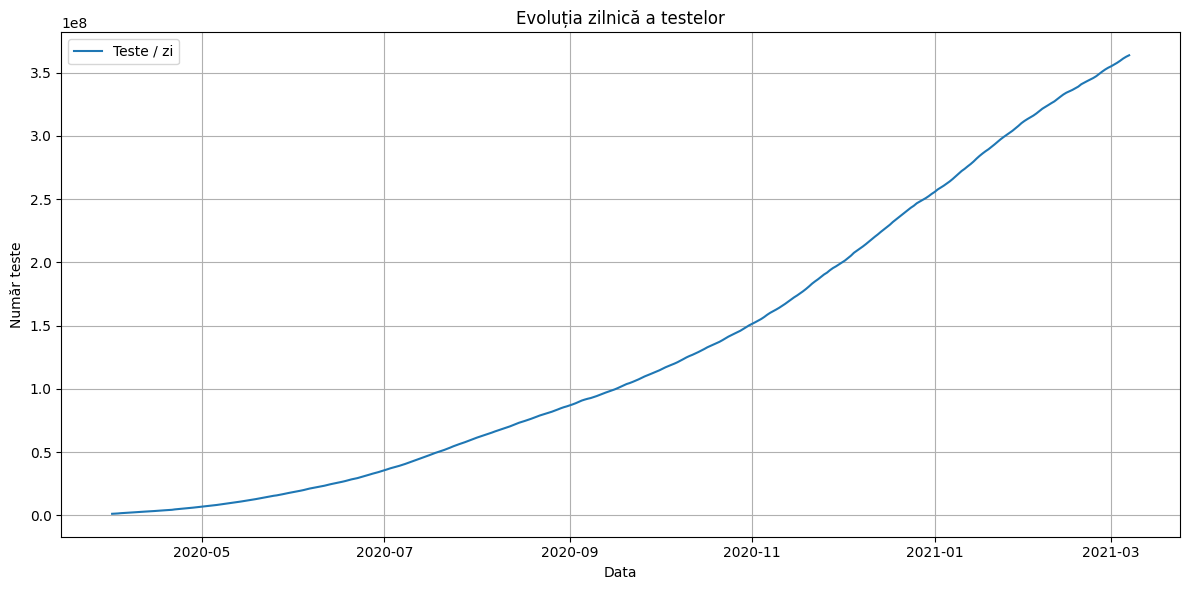

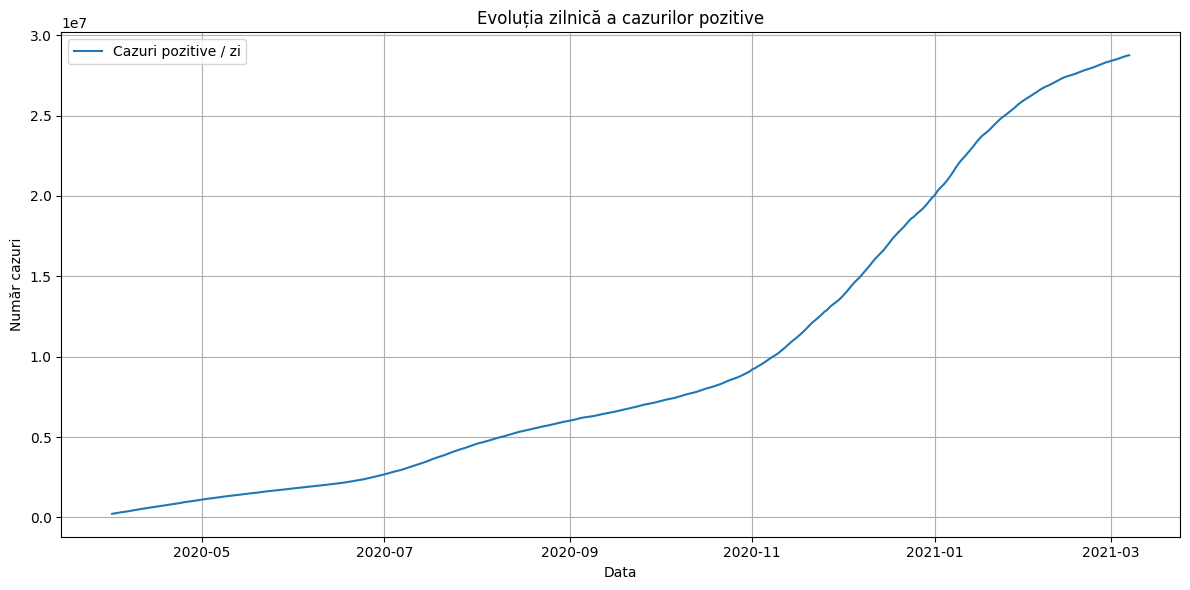

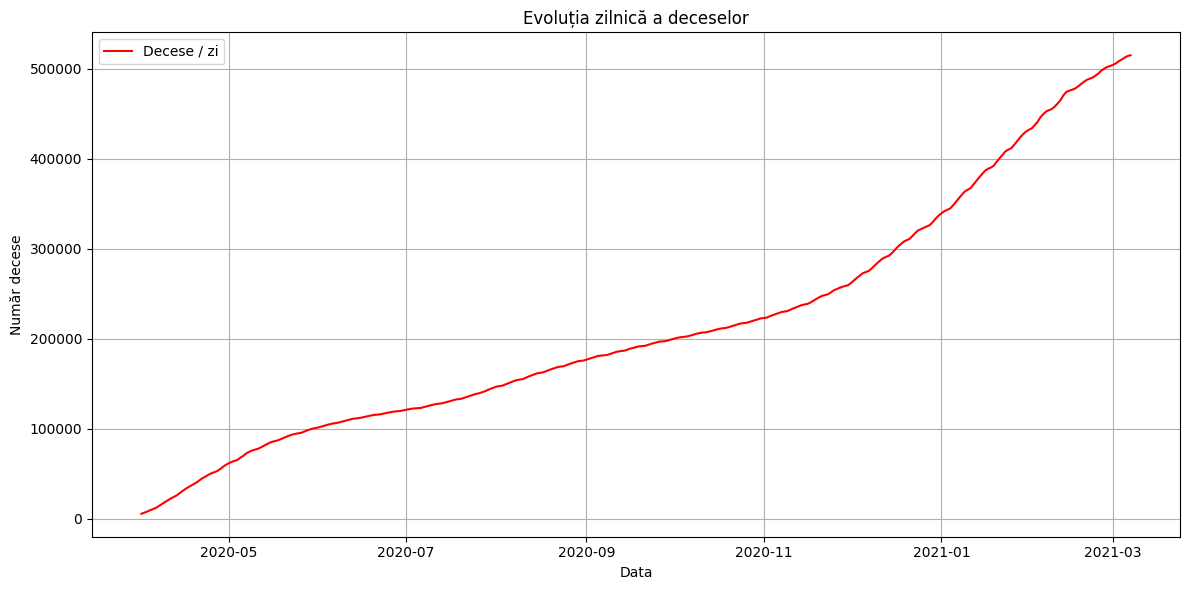

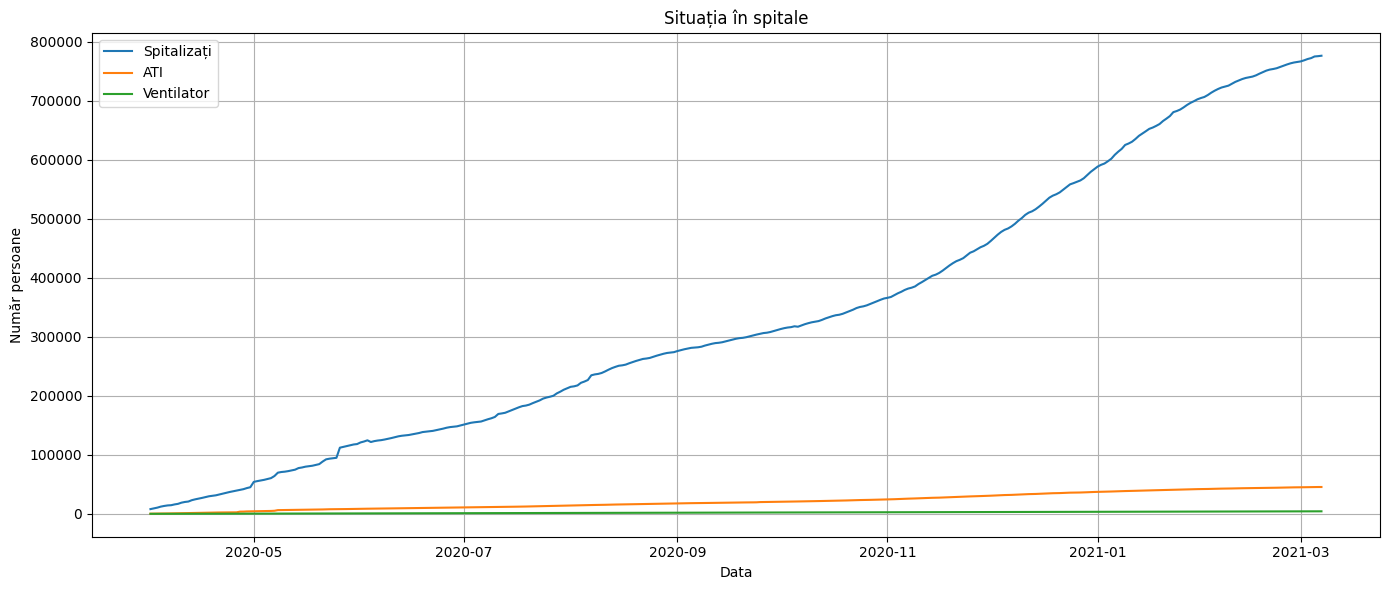

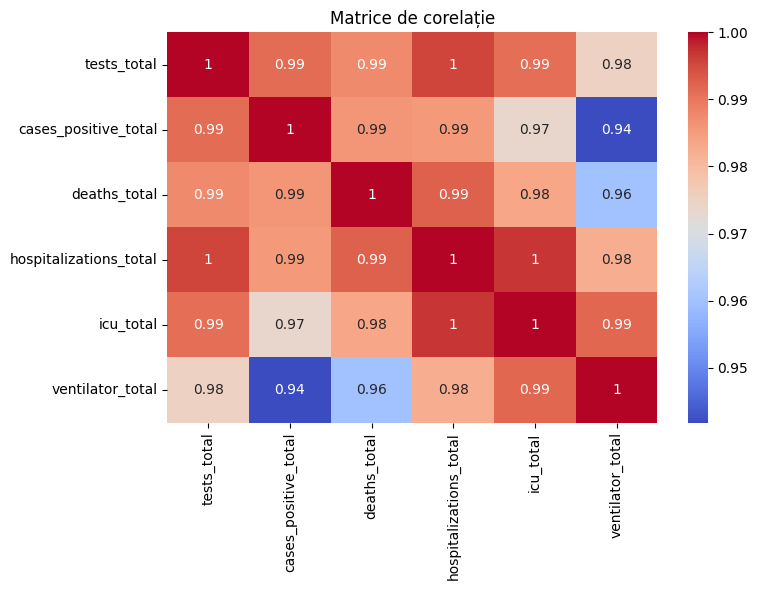

RMSE: 7358.40
+------------------+------------+
|        prediction|deaths_total|
+------------------+------------+
|         12743.125|        7800|
|         12743.125|       13974|
|         12743.125|       18027|
|          33103.25|       27871|
|          33103.25|       40199|
|53623.555555555555|       48606|
|53623.555555555555|       59646|
| 72500.11111111111|       69636|
|           95240.0|       85410|
|           95240.0|       86272|
+------------------+------------+
only showing top 10 rows

Random Forest RMSE: 6453.63


/tmp/ipython-input-55-2115035955.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


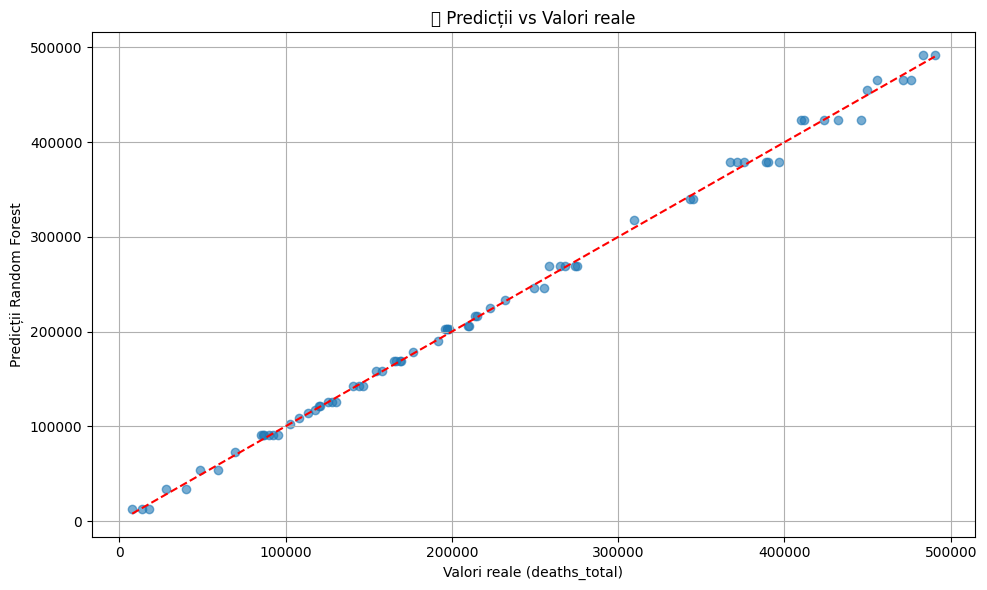

R² (coeficient de determinare): 0.9977
Accuracy în ±20% toleranță: 95.77%




Linear Regression Metrics:
R2: 0.8955
RMSE: 8736.14
MSE: 76320207.64

Decision Tree Regression Metrics:
R2: 0.9761
RMSE: 4173.84
MSE: 17420916.63

Random Forest Regression Metrics:
R2: 0.9759
RMSE: 4195.08
MSE: 17598683.64


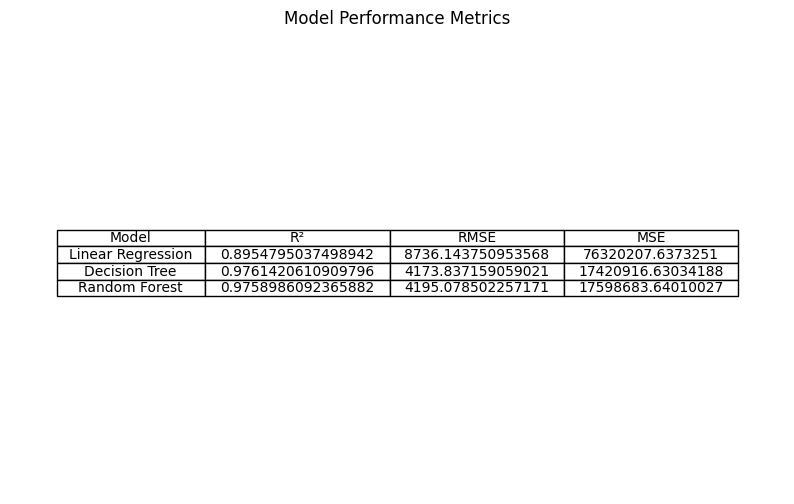

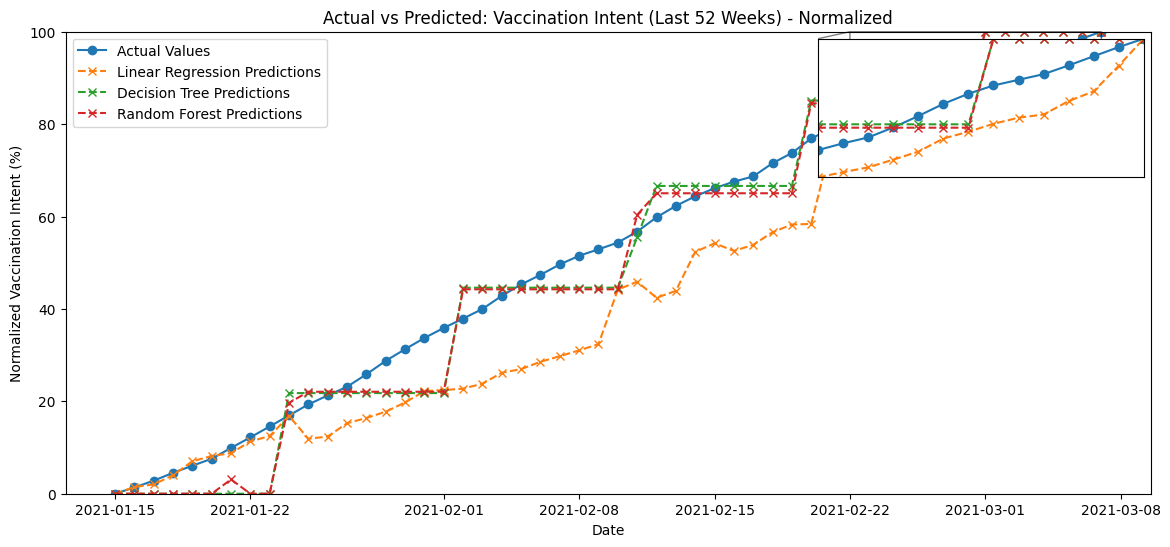

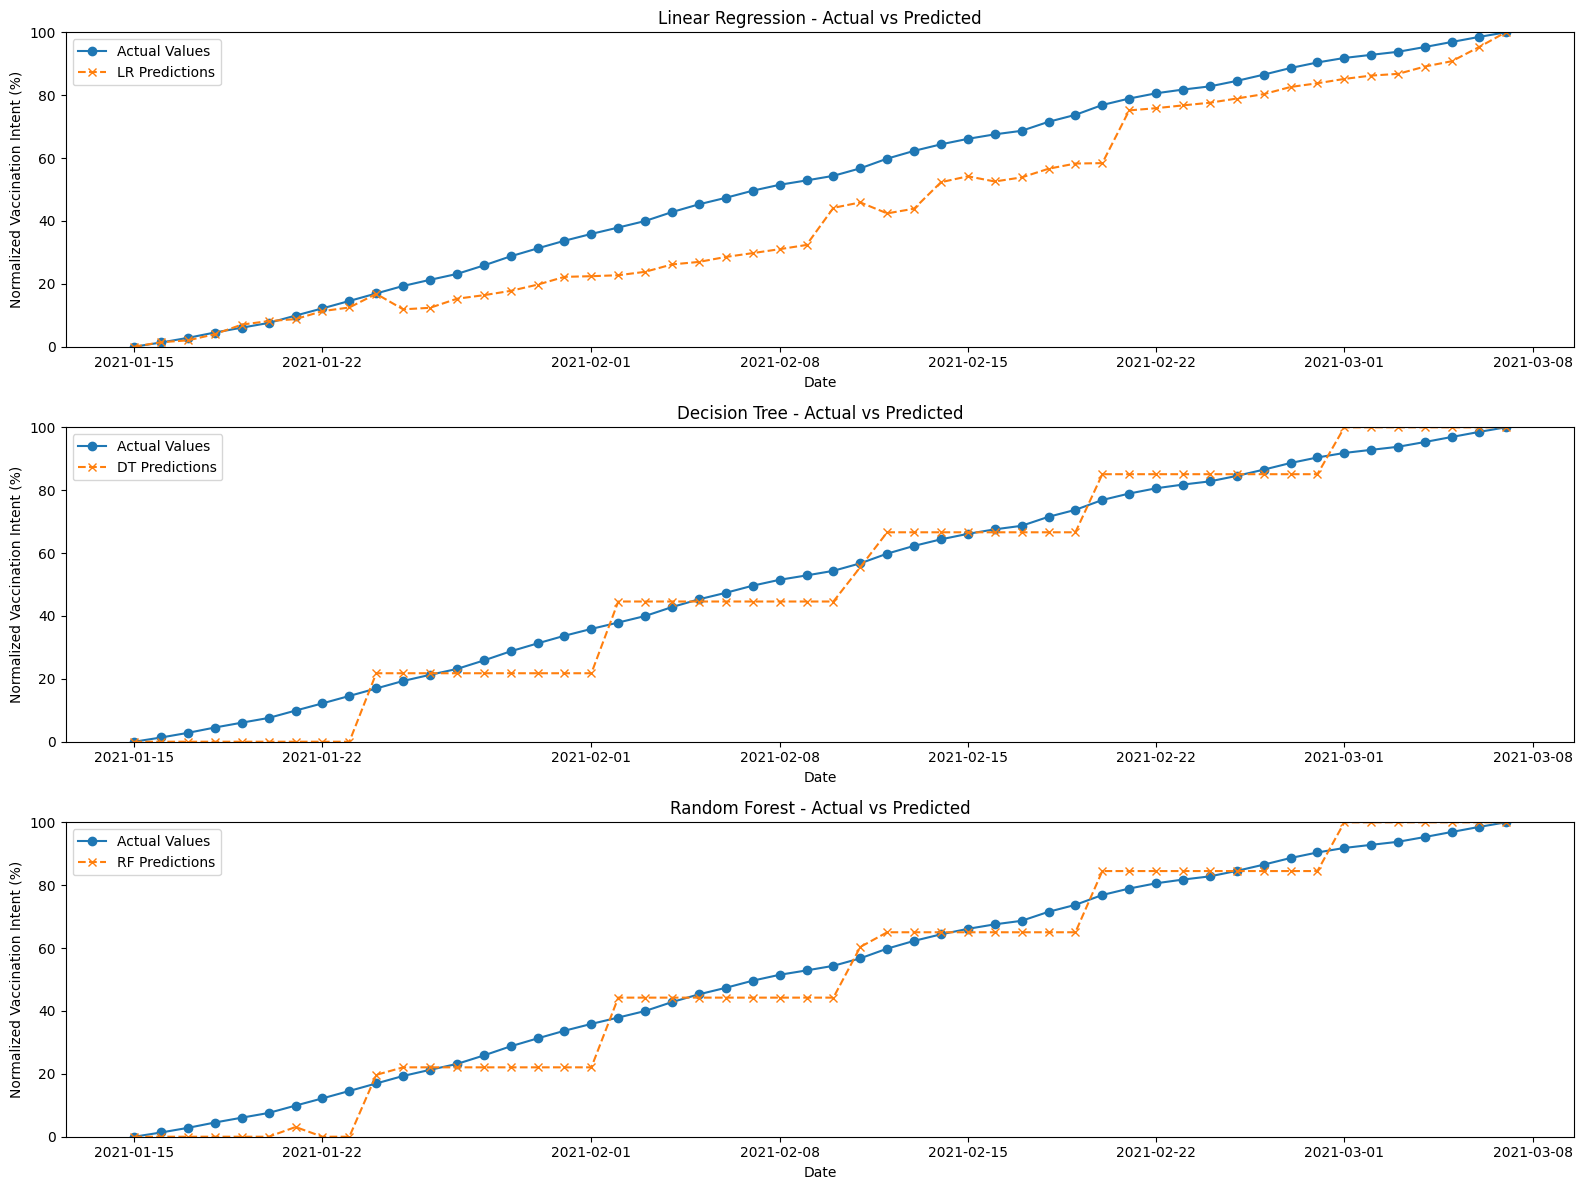

In [55]:
import pandas as pd
from google.cloud import bigquery
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col, isnan
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import log1p
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

client = bigquery.Client()
spark = SparkSession.builder.appName("COVID Tracking public data").getOrCreate()

query = """
SELECT
  date,
  tests_total,
  cases_positive_total,
  deaths_total,
  hospitalizations_total,
  icu_total,
  ventilator_total
FROM `bigquery-public-data.covid19_covidtracking.covid_public_data`
WHERE hospitilzations_current is not null
  and icu_current is not null
  and ventilator_total is not null
ORDER BY date;
"""

df = client.query(query).to_dataframe()
spark_df = spark.createDataFrame(df)
spark_df.show(10)

pandas_df = spark_df.toPandas()
pandas_df["date"] = pd.to_datetime(pandas_df["date"])
pandas_df = pandas_df.sort_values("date")

plt.figure(figsize=(12, 6))
plt.plot(pandas_df["date"], pandas_df["tests_total"], label="Teste / zi")
plt.xlabel("Data")
plt.ylabel("Număr teste")
plt.title("Evoluția zilnică a testelor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df["date"], pandas_df["cases_positive_total"], label="Cazuri pozitive / zi")
plt.xlabel("Data")
plt.ylabel("Număr cazuri")
plt.title("Evoluția zilnică a cazurilor pozitive")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df["date"], pandas_df["deaths_total"], color='red', label="Decese / zi")
plt.xlabel("Data")
plt.ylabel("Număr decese")
plt.title("Evoluția zilnică a deceselor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(pandas_df["date"], pandas_df["hospitalizations_total"], label="Spitalizați")
plt.plot(pandas_df["date"], pandas_df["icu_total"], label="ATI")
plt.plot(pandas_df["date"], pandas_df["ventilator_total"], label="Ventilator")

plt.xlabel("Data")
plt.ylabel("Număr persoane")
plt.title("Situația în spitale")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

corr_df = pandas_df[[
    "tests_total",
    "cases_positive_total",
    "deaths_total",
    "hospitalizations_total",
    "icu_total",
    "ventilator_total"
]].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corelație")
plt.tight_layout()
plt.show()

# Curățare și selecție coloane
model_df = spark_df.select(
    "tests_total",
    "cases_positive_total",
    "deaths_total",
    "hospitalizations_total",
    "icu_total",
    "ventilator_total"
).dropna()
spark_df = spark_df.withColumn("log_deaths_total", log1p("deaths_total"))

#
#
# VectorAssembler: construim coloana "features"
assembler = VectorAssembler(
    inputCols=["cases_positive_total", "hospitalizations_total", "icu_total", "ventilator_total"],
    outputCol="features"
)
assembled_df = assembler.transform(model_df).select("features", "deaths_total")

# Împărțim datele în seturi de antrenare și testare
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Decision Tree
dt = DecisionTreeRegressor(featuresCol="features", labelCol="deaths_total")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Preziceri
predictions = dt_model.transform(test_data)

# Evaluare cu RMSE
evaluator = RegressionEvaluator(
    labelCol="deaths_total",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse:.2f}")

# Afișăm 10 predicții
predictions.select("prediction", "deaths_total").show(10)

# === Random Forest ===
rf = RandomForestRegressor(featuresCol="features", labelCol="deaths_total", numTrees=50)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="deaths_total", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rmse:.2f}")

# Convertim în Pandas pentru plotting
rf_pdf = rf_predictions.select("prediction", "deaths_total").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(rf_pdf["deaths_total"], rf_pdf["prediction"], alpha=0.6)
plt.plot([rf_pdf["deaths_total"].min(), rf_pdf["deaths_total"].max()],
         [rf_pdf["deaths_total"].min(), rf_pdf["deaths_total"].max()],
         color='red', linestyle='--')
plt.xlabel("Valori reale (deaths_total)")
plt.ylabel("Predicții Random Forest")
plt.title("🔍 Predicții vs Valori reale")
plt.grid(True)
plt.tight_layout()
plt.show()

# R2 score
r2_evaluator = RegressionEvaluator(
    labelCol="deaths_total",
    predictionCol="prediction",
    metricName="r2"
)
r2 = r2_evaluator.evaluate(rf_predictions)
print(f"R² (coeficient de determinare): {r2:.4f}")
rf_pdf = rf_predictions.select("prediction", "deaths_total").toPandas()

# Definim toleranță (ex: 20% față de valoarea reală)
tolerance = 0.2
correct = abs(rf_pdf["prediction"] - rf_pdf["deaths_total"]) <= (tolerance * rf_pdf["deaths_total"])
accuracy = correct.sum() / len(correct)

print(f"Accuracy în ±20% toleranță: {accuracy * 100:.2f}%")

data = assembler.transform(spark_df)

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(data)
scaledData = scalerModel.transform(data)

# === Împărțim în train/test ===
train_data = scaledData.limit(scaledData.count() - 52)
test_data = scaledData.limit(52)

train_df = train_data.select(col("scaledFeatures").alias("features"), col("deaths_total").alias("label"))
test_df = test_data.select(col("scaledFeatures").alias("features"), col("deaths_total").alias("label"))

# === Linear Regression ===
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# === Decision Tree ===
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

# === Random Forest ===
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=50)
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# === Evaluatori ===
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")

# === Metrici LR ===
lr_r2 = evaluator_r2.evaluate(lr_predictions)
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_mse = evaluator_mse.evaluate(lr_predictions)

# === Metrici DT ===
dt_r2 = evaluator_r2.evaluate(dt_predictions)
dt_rmse = evaluator_rmse.evaluate(dt_predictions)
dt_mse = evaluator_mse.evaluate(dt_predictions)

# === Metrici RF ===
rf_r2 = evaluator_r2.evaluate(rf_predictions)
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_mse = evaluator_mse.evaluate(rf_predictions)

print("\n\n\n")
print("Linear Regression Metrics:")
print(f"R2: {lr_r2:.4f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MSE: {lr_mse:.2f}")
print()
print("Decision Tree Regression Metrics:")
print(f"R2: {dt_r2:.4f}")
print(f"RMSE: {dt_rmse:.2f}")
print(f"MSE: {dt_mse:.2f}")
print()
print("Random Forest Regression Metrics:")
print(f"R2: {rf_r2:.4f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MSE: {rf_mse:.2f}")

actual_values = np.array(test_data.select("deaths_total").collect())
actual_values = actual_values.flatten()
lr_predicted_values = np.array([row.prediction for row in lr_predictions.collect()])
dt_predicted_values = np.array([row.prediction for row in dt_predictions.collect()])
rf_predicted_values = np.array([row.prediction for row in rf_predictions.collect()])

actual_dates = np.array(df['date'][-52:])
actual_values_normalized = 100 * (actual_values - actual_values.min()) / (actual_values.max() - actual_values.min())
lr_predicted_values_normalized = 100 * (lr_predicted_values - lr_predicted_values.min()) / (lr_predicted_values.max() - lr_predicted_values.min())
dt_predicted_values_normalized = 100 * (dt_predicted_values - dt_predicted_values.min()) / (dt_predicted_values.max() - dt_predicted_values.min())
rf_predicted_values_normalized = 100 * (rf_predicted_values - rf_predicted_values.min()) / (rf_predicted_values.max() - rf_predicted_values.min())

metrics_data = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "R²": [lr_r2, dt_r2, rf_r2],
    "RMSE": [lr_rmse, dt_rmse, rf_rmse],
    "MSE": [lr_mse, dt_mse, rf_mse]
}

metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(metrics_df.columns))))

plt.title("Model Performance Metrics")
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
ax.plot(actual_dates, lr_predicted_values_normalized, label="Linear Regression Predictions", linestyle='--', marker='x')
ax.plot(actual_dates, dt_predicted_values_normalized, label="Decision Tree Predictions", linestyle='--', marker='x')
ax.plot(actual_dates, rf_predicted_values_normalized, label="Random Forest Predictions", linestyle='--', marker='x')
ax.legend()
ax.set_title("Actual vs Predicted: Vaccination Intent (Last 52 Weeks) - Normalized")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Vaccination Intent (%)")
ax.set_ylim(0, 100)

axins = inset_axes(ax, width="30%", height="30%", loc="upper right")
axins.plot(actual_dates[-14:], actual_values_normalized[-14:], label="Actual Values", marker='o')
axins.plot(actual_dates[-14:], lr_predicted_values_normalized[-14:], label="LR Predictions", linestyle='--', marker='x')
axins.plot(actual_dates[-14:], dt_predicted_values_normalized[-14:], label="DT Predictions", linestyle='--', marker='x')
axins.plot(actual_dates[-14:], rf_predicted_values_normalized[-14:], label="RF Predictions", linestyle='--', marker='x')

axins.set_xlim(actual_dates[-14], actual_dates[-1])

axins.set_ylim(min(actual_values_normalized[-14:].min(), lr_predicted_values_normalized[-14:].min(), dt_predicted_values_normalized[-14:].min(),
                   rf_predicted_values_normalized[-14:].min()),
               max(actual_values_normalized[-14:].max(), lr_predicted_values_normalized[-14:].max(), dt_predicted_values_normalized[-14:].max(),
                   rf_predicted_values_normalized[-14:].max()))

axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(16, 12))
axs[0].plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
axs[0].plot(actual_dates, lr_predicted_values_normalized, label="LR Predictions", linestyle='--', marker='x')
axs[0].legend()
axs[0].set_title("Linear Regression - Actual vs Predicted")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Normalized Vaccination Intent (%)")
axs[0].set_ylim(0, 100)

axs[1].plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
axs[1].plot(actual_dates, dt_predicted_values_normalized, label="DT Predictions", linestyle='--', marker='x')
axs[1].legend()
axs[1].set_title("Decision Tree - Actual vs Predicted")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Normalized Vaccination Intent (%)")
axs[1].set_ylim(0, 100)

axs[2].plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
axs[2].plot(actual_dates, rf_predicted_values_normalized, label="RF Predictions", linestyle='--', marker='x')
axs[2].legend()
axs[2].set_title("Random Forest - Actual vs Predicted")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Normalized Vaccination Intent (%)")
axs[2].set_ylim(0, 100)

plt.tight_layout()
plt.show()